In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import django
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "mysite.settings")
django.setup()
from django.db.models import Avg, Func
from vws_main.models import FS_Wrestler, FS_Match

class Round(Func):
  function = 'ROUND'
  arity = 2

In [78]:
yianni = FS_Wrestler.objects.get(name__startswith='Yianni')
yianni_matches = yianni.focus_wrestler2.all()
yianni_matches

<QuerySet [<FS_Match: FS_Match object (ff66)>, <FS_Match: FS_Match object (4477)>, <FS_Match: FS_Match object (HOMP)>, <FS_Match: FS_Match object (JG36)>, <FS_Match: FS_Match object (MC32*)>]>

In [95]:
matches = FS_Match.objects.filter(focus__name__contains='Yianni')
y_results = list(FS_Match.objects.filter(focus__name__contains='Yianni').values_list('result', flat=True))
y_hic2 = list(FS_Match.objects.filter(focus__name__contains='Yianni').values_list('hic2', flat=True))
y_results.pop(2)
y_results.pop(2)
y_hic2.pop(2)
y_hic2.pop(2)
print(y_results)
print(y_hic2)
print(np.corrcoef(y_results, y_hic2))

['WinD', 'WinTF', 'WinTF']
[2, 1, 0]


TypeError: cannot perform reduce with flexible type

In [63]:
for match in matches:
    print(match.result)

WinD
WinTF
None
None
WinTF


In [62]:
zz = matches.aggregate(avg_hia=Round(Avg('hia'), 2))
yy = matches.aggregate(Avg('hia'))
print(zz)
print(yy)

{'avg_hia': 2.67}
{'hia__avg': 2.6666666666666665}


In [107]:
# numeric result calculator, provides string version of result for display in tables
result_numeric = pd.Series()
def num_result(series):
    for i in series:
        if i == 'WinF':
            result_numeric.append(pd.Series(1.75), ignore_index=True)
        elif i == 'WinTF':
            result_numeric.append(pd.Series(1.50), ignore_index=True)
        elif i == 'WinD':
            result_numeric.append(pd.Series(1.25), ignore_index=True)
        elif i == 'LossD':
            result_numeric.append(pd.Series(0.75), ignore_index=True)
        elif i == 'LossTF':
            result_numeric.append(pd.Series(0.50), ignore_index=True)
        elif i == 'LossF':
            result_numeric.append(pd.Series(0.25), ignore_index=True)
    return result_numeric

Top Absolute Correlations
oGBc  oGBrate    1.0
oGBa  oGBrate    1.0
GBa   GBrate     1.0
dtype: float64

Low Absolute Correlations
Weight  Result       0.0
Result  oRecovery    0.0
        oTurn        0.0
dtype: float64


VS         0.273343
Gut        0.265606
oHIrate    0.261069
oHIc2      0.195615
GBrate     0.167365
Name: Result, dtype: float64
oVS       -0.273343
oGut      -0.265606
HIrate    -0.261069
HIc2      -0.195615
oGBrate   -0.167365
Name: Result, dtype: float64


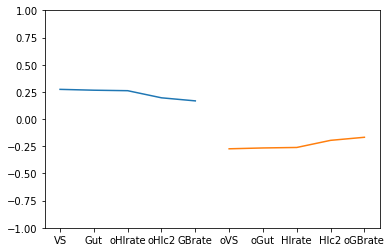

In [154]:
df = pd.read_csv('collection\stats\matchdata.csv')
df.Result = df.Result.replace(to_replace='WinF', value=1.75)
df.Result = df.Result.replace(to_replace='WinTF', value=1.50)
df.Result = df.Result.replace(to_replace='WinD', value=1.25)
df.Result = df.Result.replace(to_replace='LossD', value=0.75)
df.Result = df.Result.replace(to_replace='LossTF', value=0.50)
df.Result = df.Result.replace(to_replace='LossF', value=0.25)

df = df.drop(columns=['Date', 'Focus', 'Opponent', 'FocusTeam', 'OppTeam',
                    'Time','MatchID', 'MoV'])
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=3):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

def get_low_abs_correlations(df, n=3):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df))
print()
print("Low Absolute Correlations")
print(get_low_abs_correlations(df))

print()
print()
correlations = df.corr()['Result']
correlations.pop('Result')
sorted_corrs_top = correlations.sort_values(ascending=False)[:5]
sorted_corrs_bottom = correlations.sort_values(ascending=True)[:5]
print(sorted_corrs_top)
print(sorted_corrs_bottom)
top=1
bottom=-1
plt.ylim((bottom, top))
plt.plot(sorted_corrs_top)
plt.plot(sorted_corrs_bottom)